In [ ]:
import pandas as pd
%matplotlib inline
from scipy.misc import imread
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.utils import resample
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

xray_dir = '/home/dattran/data/xray/'
# https://elitedatascience.com/imbalanced-classes
# https://github.com/dattran2346/2015lab5/blob/master/Classification.ipynb

#### Take a look at the data

In [ ]:
df = pd.read_csv('../csv/xray.csv')
df.head()

#### Utility function

In [ ]:
## Let display some image 
def plot_sample_xray(pneumonia=True, n=3):
    image_files = df[df.pneumonia == pneumonia].sample(n=n)
    print(image_files)
    image_files = xray_dir + image_files.image.values
    for file in image_files:
        print(file)
        image = cv2.imread(file)
        print(image.shape)
        plt.figure()
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

In [ ]:
def performance_on_test(clf, Xtest, ytest):
    ypred = clf.predict(Xtest)
    print('Overal')
    print(classification_report(ytest, ypred))
    print('\tPredicted')
    print('Observed  0\t1')
    matrix = confusion_matrix(ytest, ypred)
    print('\t0', matrix[0])
    print('\t1', matrix[1])
    print('Accuracy', clf.score(Xtest, ytest))

### Let's plot some normal xray

       patient_id             image  pneumonia  follow_up  patient_age  \
50880       23068  00023068_003.png      False          3           72   
37295       16075  00016075_004.png      False          4           62   
10903        4863  00004863_002.png      False          2           27   

      patient_gender view_position  
50880              F            AP  
37295              M            AP  
10903              F            PA  
/home/dattran/data/xray/00023068_003.png
(1024, 1024, 3)
/home/dattran/data/xray/00016075_004.png
(1024, 1024, 3)
/home/dattran/data/xray/00004863_002.png
(1024, 1024, 3)


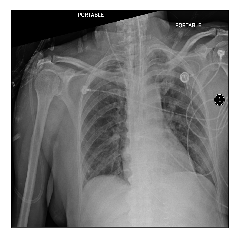

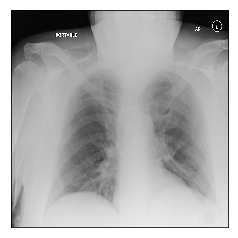

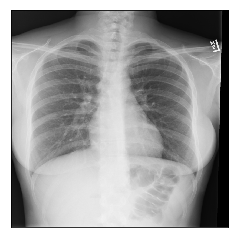

In [17]:
plot_sample_xray(pneumonia=False)

       patient_id             image  pneumonia  follow_up  patient_age  \
48642       21710  00021710_002.png       True          2           59   
11310        5032  00005032_000.png       True          0           53   
32133       13922  00013922_012.png       True         12           52   

      patient_gender view_position  
48642              M            PA  
11310              M            PA  
32133              M            AP  
/home/dattran/data/xray/00021710_002.png
(1024, 1024, 3)
/home/dattran/data/xray/00005032_000.png
(1024, 1024, 3)
/home/dattran/data/xray/00013922_012.png
(1024, 1024, 3)


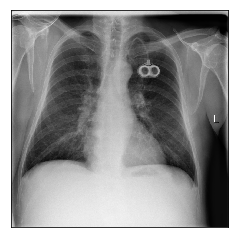

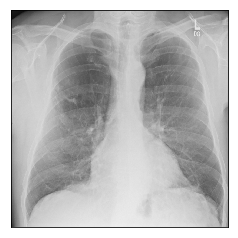

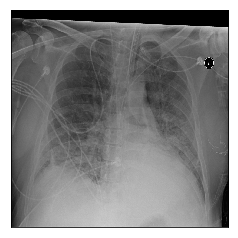

In [18]:
### Now plot some pneumonia image
plot_sample_xray(pneumonia=True)

In [19]:
### Get all the pneumonia sample
df_pneumonia = df[df.pneumonia == True]
df_normal = df[df.pneumonia == False]
print('Pneumoia patient in dataset:', df_pneumonia.shape)
print('Normal patient in dataset:', df_normal.shape)

Pneumoia patient in dataset: (1353, 7)
Normal patient in dataset: (60410, 7)


Plainly predict all the image to be normal will yield the accuracy of 99.77%, that the baseline we have to beat :)))

### Balance the dataset first

In [20]:
# for simplicity, consider only a small subset of images, about ~500 images for each label
n_images = 200 # change n to larger number when ready
n_normal = int(n_images * (1 + np.random.uniform(-0.2, 0.2)))
n_pneumonia = int(n_images * (1 + np.random.uniform(-0.2, 0.2)))
print(n_normal, n_pneumonia)

209 214


In [21]:
df_pneumonia_small = df_pneumonia.sample(n=n_pneumonia)
df_normal_small = df_normal.sample(n=n_normal)
df_small = pd.concat([df_normal_small, df_pneumonia_small])
images = [cv2.imread(xray_dir + file).reshape(-1, 1).squeeze() for file in df_small.image.values]
print(images[0].shape)

(3145728,)


### Trying PCA to extract feature form the image

In [23]:
from sklearn.decomposition import PCA
n_components = 60 # change this number
pca = PCA(n_components=n_components)
X = pca.fit_transform(images)

MemoryError: 

In [ ]:
print('60 pc explained:', pca.explained_variance_ratio_.sum())
print(X.shape)
print(pca.components_.shape)

In [ ]:
print(pca.explained_variance_ratio_*100)
print(pca.explained_variance_ratio_.shape)

In [ ]:
df_pca = pd.DataFrame({'y': df_small.pneumonia})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df_pca['pc%i' % (i+1)] = X[:, i]
df_pca.head()

#### Let's visualize PCA
eigenfaces of xray

In [ ]:
def normit(a):
    a = (a - a.min()) / (a.max() - a.min())
    a = a * 256
    return np.round(a)

def getNC(pc, j):
    size = 1024 * 1024 * 3
    r = pc.components_[j][0:size:3]
    g = pc.components_[j][1:size:3]
    b = pc.components_[j][2:size:3]
    r = normit(r)
    g = normit(g)
    b = normit(b)
    return r, g, b

def display_component(pc, j):
    r, g, b = getNC(pc, j)
    rgbArray = np.empty((1024, 1024, 3), 'uint8')
    rgbArray[..., 0] = r.reshape(1024, 1024)
    rgbArray[..., 1] = g.reshape(1024, 1024)
    rgbArray[..., 2] = b.reshape(1024, 1024)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

In [ ]:
display_component(pca, 0)

In [ ]:
display_component(pca, 1)

In [ ]:
colors = ['r', 'b']
for label, color in zip(df_small.pneumonia.unique(), colors):
    mask = df_small.pneumonia == label
    plt.scatter(df_pca[mask].pc1, df_pca[mask].pc2, c=color, label=label)
plt.legend()
plt.xlabel('pc1')
plt.ylabel('pc2')

Look like no hope for Linear classifier

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label, color in zip(df_small.pneumonia.unique(), colors):
    mask = df_small.pneumonia == label
    ax.scatter(df_pca[mask].pc1, df_pca[mask].pc2, df_pca[mask].pc3, color=color, label=label)


In [ ]:
sns.heatmap(df_pca.corr())

#### Classification on reduce feature space

In [19]:
X = df_pca.drop('y', axis=1)
y = df_pca.y
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, random_state=1)

/home/dattran/miniconda2/envs/dat/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Algos 1: SVM 
http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py

PCA reduce the dimension, hence help to reduce the Curse of Dimensionality. However, SVM do the classifying using the kernel trick to increase the feature dimension. Isn't it nonsense?

In [20]:
from sklearn.svm import SVC
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
svm_clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm_clf.fit(Xtrain, ytrain)
print('Best svm clf', svm_clf.best_estimator_)

Best svm clf SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [21]:
performance_on_test(svm_clf, Xtest, ytest)

Overal
             precision    recall  f1-score   support

      False       0.00      0.00      0.00        36
       True       0.56      1.00      0.71        45

avg / total       0.31      0.56      0.40        81

	Predicted
Observed  0	1
	0 [ 0 36]
	1 [ 0 45]
Accuracy 0.5555555555555556


/home/dattran/miniconda2/envs/dat/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Look like no hope for SVM